In [138]:
using Pkg
Pkg.activate("../..")

  Activating project at `c:\Users\ladis\GitHub\SparseSpikes`


In [139]:
using Plots, LinearAlgebra, LaTeXStrings, Random
using SparseSpikes

Define ground truth amplitudes and positions

In [140]:
domain = [0, 1]

x₀ = [0.1, 0.5, 0.9]
a₀ = [1.5, 0.8, -1.0]

# 20 random atoms
# x₀ = rand(30)
# a₀ = randn(30)

μ₀ = DiscreteMeasure(x₀, a₀)

DiscreteMeasure{Float64}([0.1, 0.5, 0.9], [1.5, 0.8, -1.0], 1, 3)

In [141]:
# Define noise level
noise_level = 0.05

# Seed for noise
Random.seed!(22)

TaskLocalRNG()

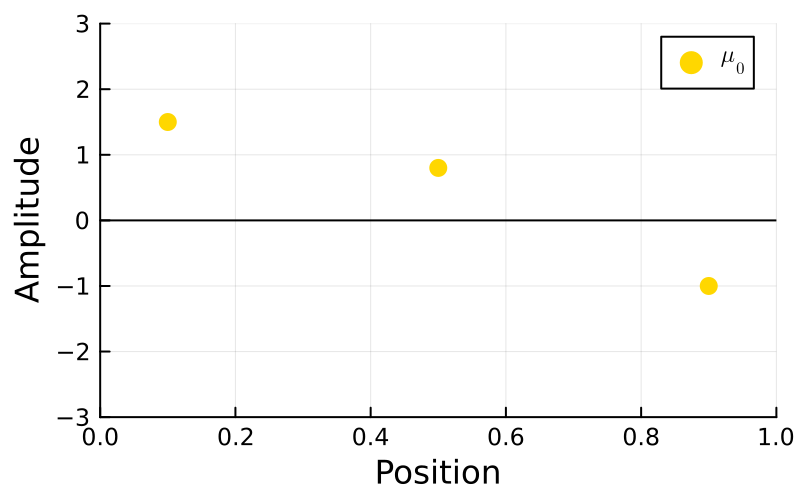

In [142]:
n_coarse_grid = 20
n_plt_grid = 1000

coarse_grid = build_grid(domain, n_coarse_grid)
plt_grid = build_grid(domain, n_plt_grid)

plot_size = (400, 250) .* 1
plt = plot(xlims=extrema(domain), ylims=(-3, 3), xlabel="Position", ylabel="Amplitude", legend=:topright, size=plot_size, dpi=200)
hline!(plt, [0], linestyle=:solid, color=:black, label="")

plot_spikes!(plt, μ₀, label=L"μ_0", color=:gold)

In [143]:
ops = gaussian_operators_1D(0.05, coarse_grid)

Operators(SparseSpikes.var"#ϕ!#gaussian_operators_1D##185"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, SparseSpikes.var"#wrap01#gaussian_operators_1D##184", Float64, Float64, Float64, Int64}(0.0:0.05:0.95, SparseSpikes.var"#wrap01#gaussian_operators_1D##184"(), 0.22360679774997896, 3.3591355541203045, 199.99999999999997, 20), SparseSpikes.var"#ϕ#gaussian_operators_1D##186"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, SparseSpikes.var"#ϕ!#gaussian_operators_1D##185"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, SparseSpikes.var"#wrap01#gaussian_operators_1D##184", Float64, Float64, Float64, Int64}}(0.0:0.05:0.95, SparseSpikes.var"#ϕ!#gaussian_operators_1D##185"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, SparseSpikes.var"#wrap01#gaussian_operators_1D##184", Float64, Float64, Float64, Int64}(0.0:0.05:0.95, Spa

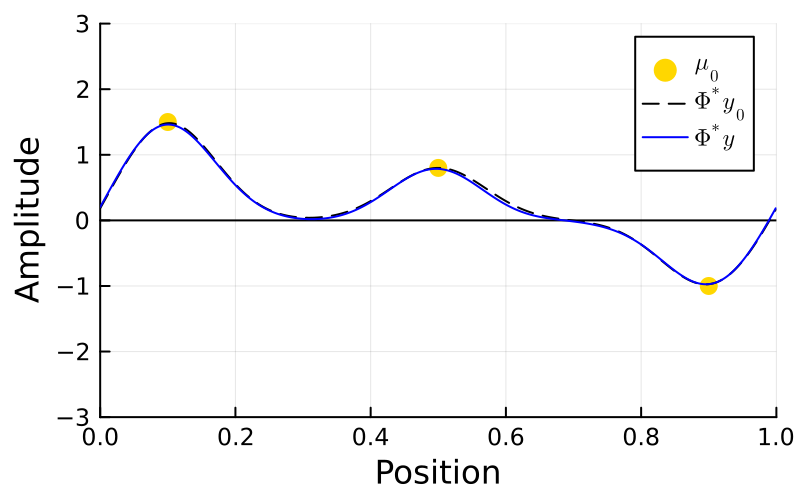

In [144]:
# Calculate the observation y₀ = Φμ₀
y₀ = ops.Φₓ(μ₀...)

# Add noise to the observation y = y₀ + ϵ
sigma = noise_level * norm(y₀)
ϵ = randn(length(y₀))
ϵ = ϵ / norm(ϵ) * sigma
y = y₀ + ϵ

plt_obs = deepcopy(plt)

plot!(plt_obs, plt_grid, ops.Φₓᴴ(y₀, grid=plt_grid), label=L"Φ^{\ast}y_0", color=:black, linestyle=:dash)
plot!(plt_obs, plt_grid, ops.Φₓᴴ(y, grid=plt_grid), label=L"Φ^{\ast}y", color=:blue)

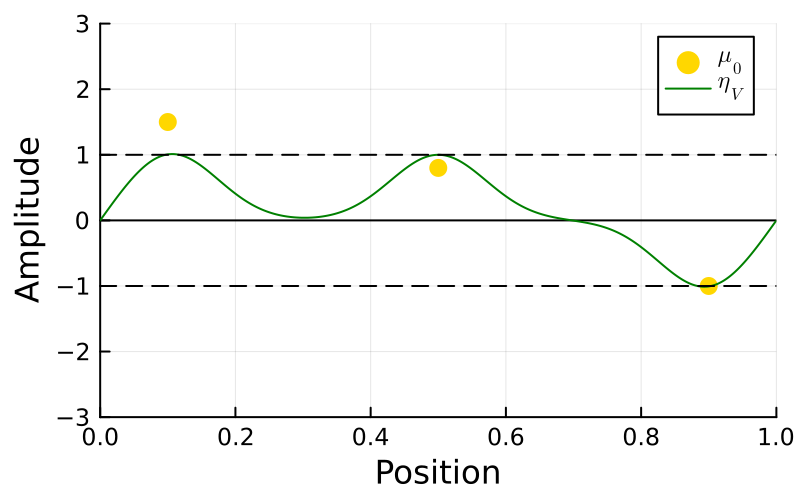

In [145]:
ηᵥ = ops.ηᵥ(μ₀...)

plt_cert = deepcopy(plt)

plot!(plt_cert, plt_grid, ηᵥ(plt_grid), label=L"η_V", color=:green)
hline!(plt_cert, [1, -1], linestyle=:dash, color=:black, label="")

## Sliding Frank-Wolfe

In [146]:
# Define λ the regularisation parameter
λ = 0.05

prob_sfw = BLASSO(y, ops, domain, n_coarse_grid, λ=λ)

solve!(prob_sfw, :SFW, options=Dict(:maxits => 30))

SFW iterations:  3    Time: 0:00:04

BLASSO([0.07027987712643746, 0.6991108069668678, 1.0995428444252189, 0.6524806930562523, 0.1589869733185238, 0.011564877478538349, -0.010935393376867159, -0.01240277091399045, 0.06664018395206908, 0.374381152627471, 0.6043746694045592, 0.3303428464606193, 0.034571552916935575, -0.003537983083691106, 0.01838157879941787, -0.05051193372742551, -0.08244056753333302, -0.4470161217814052, -0.7558910143099519, -0.4498267653955629], Operators(SparseSpikes.var"#ϕ!#gaussian_operators_1D##185"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, SparseSpikes.var"#wrap01#gaussian_operators_1D##184", Float64, Float64, Float64, Int64}(0.0:0.05:0.95, SparseSpikes.var"#wrap01#gaussian_operators_1D##184"(), 0.22360679774997896, 3.3591355541203045, 199.99999999999997, 20), SparseSpikes.var"#ϕ#gaussian_operators_1D##186"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, SparseSpikes.var"#ϕ!#gaussian_operators_1D##185"{StepRange

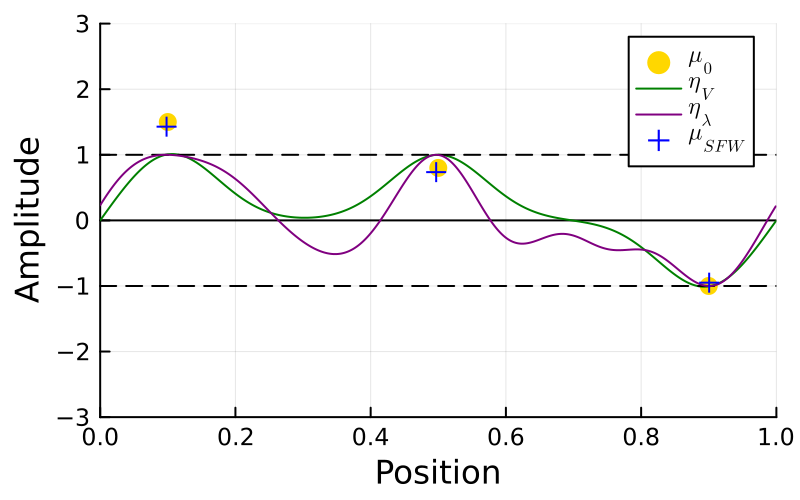

In [147]:
plt_sfw = deepcopy(plt_cert)

ηλ = prob_sfw.η(plt_grid)
plot!(plt_sfw, plt_grid, ηλ, label=L"η_λ", color=:purple)
plot_spikes!(plt_sfw, prob_sfw.μ, label=L"μ_{SFW}", color=:blue, marker=:cross, markerstrokewidth=2)